In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_breast_cancer()#load_iris()
X = iris.data
y = iris.target

In [34]:
X[0]

array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
       3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
       8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
       3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
       1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01])

In [27]:
def quantize_data(data, bits):
    levels = 2 ** bits
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    
    quantized_data = np.round(((data - min_val) / (max_val - min_val)) * (levels - 1))
    quantized_data = (quantized_data * (max_val - min_val) / (levels - 1)) + min_val
    
    return quantized_data

# Quantization 8/4/2 bits
quantized_8bit = quantize_data(X, 8)
quantized_4bit = quantize_data(X, 4)
quantized_2bit = quantize_data(X, 2)

# Display the results
print("Original Data (first 5 samples):\n", X[:5])
print("\nQuantized Data (8-bit, first 5 samples):\n", quantized_8bit[:5])
print("\nQuantized Data (4-bit, first 5 samples):\n", quantized_4bit[:5])
print("\nQuantized Data (2-bit, first 5 samples):\n", quantized_2bit[:5])

Original Data (first 5 samples):
 [[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
 [1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
  2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
 [1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
  3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]]

Quantized Data (8-bit, first 5 samples):
 [[1.42339216e+01 1.71231373e+00 2.43066667e+00 1.56211765e+01
  1.27003922e+02 2.79960784e+00 3.05388235e+00 2.79647059e-01
  2.28713725e+00 5.64627451e+00 1.03952941e+00 3.92505882e+00
  1.06421961e+03]
 [1.32056863e+01 1.77184314e+00 2.13733333e

In [95]:
# Prepare models
models = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier()),
    'k-NN': OneVsRestClassifier(KNeighborsClassifier()),
    'SVM': OneVsRestClassifier(SVC(gamma='auto'))
}

quantizations = {8: quantized_8bit, 4: quantized_4bit, 2: quantized_2bit}

results = {}
skf = StratifiedKFold(n_splits=5)


for bit_depth, quantized_X in quantizations.items():
    print(f"\nQuantization: {bit_depth}-bit")
    results[bit_depth] = {
        model_name: {
            'mean_accuracy': np.mean(scores := cross_val_score(model, quantized_X, y, cv=skf, scoring='accuracy')),
            'std_accuracy': np.std(scores)
        }
        for model_name, model in models.items()
    }
    # Print results for each model at the current bit depth
    for model_name, metrics in results[bit_depth].items():
        print(f"{model_name}: Mean Accuracy = {metrics['mean_accuracy']:.3f}, "
              f"Std Dev = {metrics['std_accuracy']:.3f}")



Quantization: 8-bit
Decision Tree: Mean Accuracy = 1.000, Std Dev = 0.000
k-NN: Mean Accuracy = 1.000, Std Dev = 0.000
SVM: Mean Accuracy = 0.667, Std Dev = 0.000

Quantization: 4-bit
Decision Tree: Mean Accuracy = 1.000, Std Dev = 0.000
k-NN: Mean Accuracy = 1.000, Std Dev = 0.000
SVM: Mean Accuracy = 0.993, Std Dev = 0.013

Quantization: 2-bit
Decision Tree: Mean Accuracy = 1.000, Std Dev = 0.000
k-NN: Mean Accuracy = 1.000, Std Dev = 0.000
SVM: Mean Accuracy = 1.000, Std Dev = 0.000


### Task 3: Comparison with Full-Precision Models

In [96]:
full_precision_X = X 

# Perform 5-fold cross-validation for full-precision data
skf = StratifiedKFold(n_splits=5)
results1 = {'Full-Precision': {}}

print("Full-Precision Model Results:")
for model_name, model in models.items():
    cv_scores = cross_val_score(model, full_precision_X, y, cv=skf, scoring='accuracy')
    results1['Full-Precision'][model_name] = {
        'mean_accuracy': np.mean(cv_scores),
        'std_accuracy': np.std(cv_scores)
    }
    print(f"{model_name}: Mean Accuracy = {results1['Full-Precision'][model_name]['mean_accuracy']:.3f}, "
          f"Std Dev = {results1['Full-Precision'][model_name]['std_accuracy']:.3f}")



Full-Precision Model Results:
Decision Tree: Mean Accuracy = 1.000, Std Dev = 0.000
k-NN: Mean Accuracy = 1.000, Std Dev = 0.000
SVM: Mean Accuracy = 1.000, Std Dev = 0.000


In [83]:
results.update(results1)
# Data for plotting
precision_levels = [2, 4, 8, 'Full-Precision']
models = ['Decision Tree', 'k-NN', 'SVM']
colors = {'Decision Tree': 'blue', 'k-NN': 'green', 'SVM': 'red'}


# Extract mean accuracy for each model at different precision levels

accuracy_data_iris = {
    'Decision Tree': [0.820, 0.940, 0.953, 0.953],  # 2-bit, 4-bit, 8-bit, Full-Precision
    'k-NN': [0.773, 0.967, 0.973, 0.973],          # 2-bit, 4-bit, 8-bit, Full-Precision
    'SVM': [0.820, 0.960, 0.980, 0.980]            # 2-bit, 4-bit, 8-bit, Full-Precision
}


accuracy_data_wine = {
    'Decision Tree': [0.928, 0.899, 0.877, 0.871],  # 2-bit, 4-bit, 8-bit, Full-Precision
    'k-NN': [0.860, 0.765, 0.669, 0.692],          # 2-bit, 4-bit, 8-bit, Full-Precision
    'SVM': [0.871, 0.708, 0.439, 0.455]            # 2-bit, 4-bit, 8-bit, Full-Precision
}


accuracy_data_breast_cancer = {
    'Decision Tree': [0.921, 0.951, 0.928, 0.916],  # 2-bit, 4-bit, 8-bit, Full-Precision
    'k-NN': [0.942, 0.914, 0.930, 0.928],          # 2-bit, 4-bit, 8-bit, Full-Precision
    'SVM': [0.921, 0.889, 0.627, 0.627]            # 2-bit, 4-bit, 8-bit, Full-Precision
}

In [84]:
std_dev_iris = {
    'Decision Tree': [0.081, 0.057, 0.058, 0.045],  # 2-bit, 4-bit, 8-bit, Full-Precision
    'k-NN': [0.033, 0.021, 0.025, 0.022],          # 2-bit, 4-bit, 8-bit, Full-Precision
    'SVM': [0.062, 0.039, 0.016, 0.016]            # 2-bit, 4-bit, 8-bit, Full-Precision
}

std_dev_wine = {
    'Decision Tree': [0.060, 0.037, 0.062, 0.057],  # 2-bit, 4-bit, 8-bit, Full-Precision
    'k-NN': [0.049, 0.089, 0.060, 0.066],          # 2-bit, 4-bit, 8-bit, Full-Precision
    'SVM': [0.051, 0.059, 0.049, 0.035]            # 2-bit, 4-bit, 8-bit, Full-Precision
}

std_dev_breast_cancer = {
    'Decision Tree': [0.022, 0.021, 0.016, 0.016],  # 2-bit, 4-bit, 8-bit, Full-Precision
    'k-NN': [0.031, 0.023, 0.025, 0.022],          # 2-bit, 4-bit, 8-bit, Full-Precision
    'SVM': [0.017, 0.015, 0.004, 0.004]            # 2-bit, 4-bit, 8-bit, Full-Precision
}


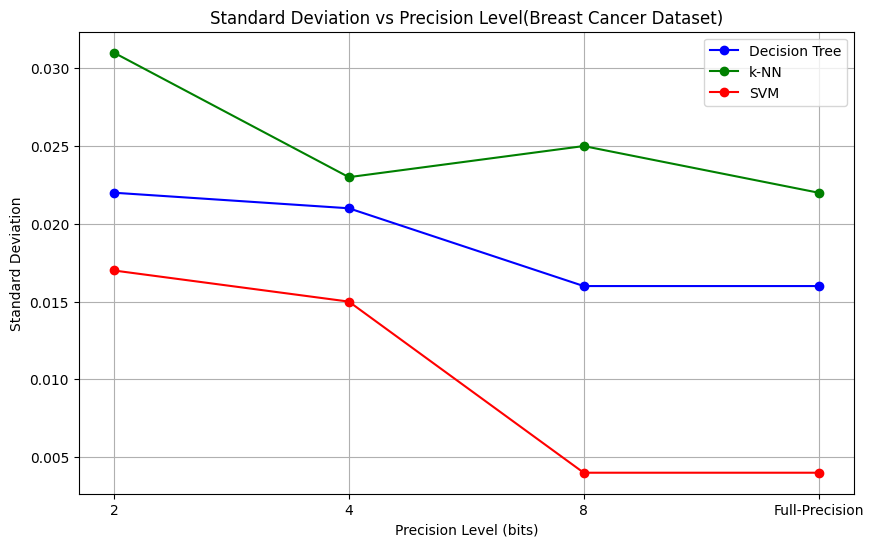

In [88]:
# Plot accuracy vs. precision level for each model
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(precision_levels, std_dev_breast_cancer[model], marker='o', color=colors[model], label=model)

# Customize the plot
plt.xlabel('Precision Level (bits)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Precision Level(Breast Cancer Dataset)')
plt.legend()
plt.grid(True)
plt.show()


Accuracy with 8-bit quantized gradients: 1.0000
Accuracy with 4-bit quantized gradients: 1.0000
Accuracy with 2-bit quantized gradients: 1.0000


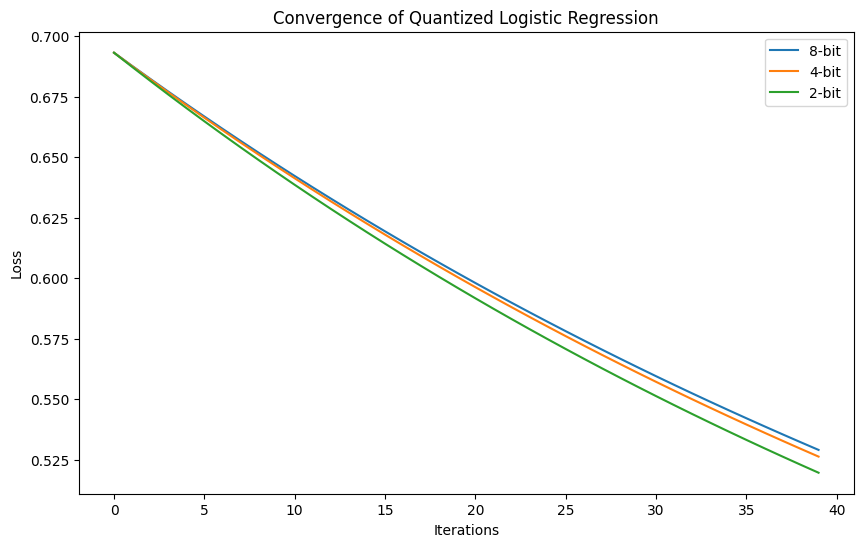

In [35]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load and preprocess the IRIS dataset
data = load_iris()
X = data.data
y = (data.target > 0).astype(int)  # Convert to binary classification for simplicity
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sigmoid function for logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def quantize_data(data, bits):
    levels = 2 ** bits
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    
    quantized_data = np.round(((data - min_val) / (max_val - min_val)) * (levels - 1))
    quantized_data = (quantized_data * (max_val - min_val) / (levels - 1)) + min_val
    
    return quantized_data

# Logistic Regression with Quantized Gradient Updates
class QuantizedLogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000, quant_bits=8):
        self.lr = lr
        self.n_iter = n_iter
        self.quant_bits = quant_bits
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.loss_history = []
        
        # Perform quantized gradient SGD
        for _ in range(self.n_iter):
            predictions = sigmoid(np.dot(X, self.weights))
            error = predictions - y
            gradient = np.dot(X.T, error) / X.shape[0]
            
            # Quantize gradient using the provided function
            quantized_gradient = quantize_data(gradient, bits=self.quant_bits)
            
            # Update weights
            self.weights -= self.lr * quantized_gradient
            
            # Compute loss for convergence analysis
            loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            self.loss_history.append(loss)
    
    def predict(self, X):
        return (sigmoid(np.dot(X, self.weights)) >= 0.5).astype(int)

# Train quantized logistic regression with different bit precision
precisions = [8, 4, 2]
results = {}

for bits in precisions:
    model = QuantizedLogisticRegression(lr=0.01, n_iter=40, quant_bits=bits)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[bits] = {
        'accuracy': accuracy,
        'loss_history': model.loss_history
    }
    print(f"Accuracy with {bits}-bit quantized gradients: {accuracy:.4f}")

# Plot convergence
plt.figure(figsize=(10, 6))
for bits in precisions:
    plt.plot(results[bits]['loss_history'], label=f'{bits}-bit')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Convergence of Quantized Logistic Regression')
plt.legend()
plt.show()

Accuracy with 8-bit quantized input and 4-bit quantized gradient: 0.9000
Accuracy with 4-bit quantized input and 4-bit quantized gradient: 0.8667
Accuracy with 2-bit quantized input and 4-bit quantized gradient: 0.9333


TypeError: unhashable type: 'dict'

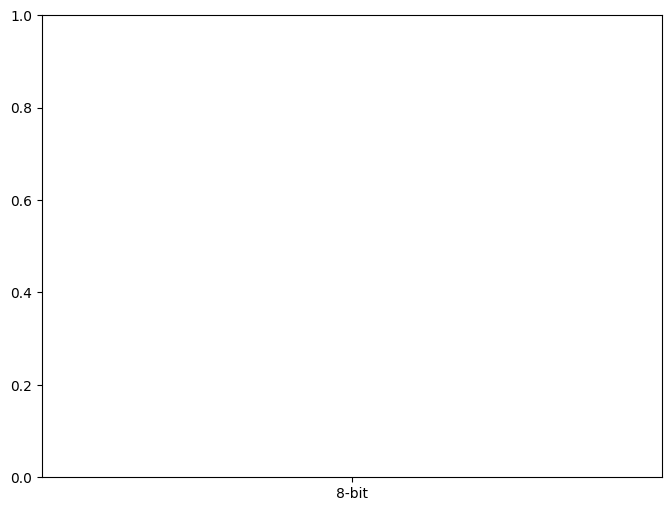

In [16]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

# Load and preprocess the IRIS dataset
data = load_iris()
X = data.data
y = data.target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a quantization function
def quantize_data(data, bits):
    levels = 2 ** bits
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    
    quantized_data = np.round(((data - min_val) / (max_val - min_val)) * (levels - 1))
    quantized_data = (quantized_data * (max_val - min_val) / (levels - 1)) + min_val
    
    return quantized_data

# Custom Quantized Logistic Regression with 4-bit quantized gradient updates
class QuantizedLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, n_iter=1000, gradient_bits=4):
        self.lr = lr
        self.n_iter = n_iter
        self.gradient_bits = gradient_bits
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        
        for _ in range(self.n_iter):
            # Make predictions
            z = np.dot(X, self.weights)
            predictions = 1 / (1 + np.exp(-z))
            
            # Calculate the gradient and quantize it
            error = predictions - y
            gradient = np.dot(X.T, error) / X.shape[0]
            quantized_gradient = quantize_data(gradient, bits=self.gradient_bits)
            
            # Update weights
            self.weights -= self.lr * quantized_gradient

    def predict(self, X):
        z = np.dot(X, self.weights)
        return (1 / (1 + np.exp(-z)) >= 0.5).astype(int)
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights)
        probabilities = 1 / (1 + np.exp(-z))
        return np.column_stack([1 - probabilities, probabilities])

# Experiment with quantized inputs (8, 4, 2-bit) and fixed 4-bit gradient quantization
precisions = [8, 4, 2]
results = {}

for bits in precisions:
    # Quantize input data
    X_train_quantized = quantize_data(X_train, bits)
    X_test_quantized = quantize_data(X_test, bits)
    
    # Use OneVsRestClassifier with the custom logistic regression model
    quantized_logreg_model = OneVsRestClassifier(
        QuantizedLogisticRegression(lr=0.01, n_iter=1000, gradient_bits=4)
    )
    
    # Train and evaluate
    quantized_logreg_model.fit(X_train_quantized, y_train)
    y_pred = quantized_logreg_model.predict(X_test_quantized)
    accuracy = accuracy_score(y_test, y_pred)
    
    # results[bits] = accuracy
    results[bits] = {
        'accuracy': accuracy,
    }
    print(f"Accuracy with {bits}-bit quantized input and 4-bit quantized gradient: {accuracy:.4f}")


# Visualize results
plt.figure(figsize=(8, 6))
plt.bar([str(bits) + '-bit' for bits in precisions], [results[bits] for bits in precisions])
plt.xlabel('Input Quantization Level')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Different Input Quantization Levels (4-bit Gradient)')
plt.show()



Accuracy with 8-bit quantized input and 4-bit quantized gradient: 0.9000
Accuracy with 4-bit quantized input and 4-bit quantized gradient: 0.8667
Accuracy with 2-bit quantized input and 4-bit quantized gradient: 0.9333


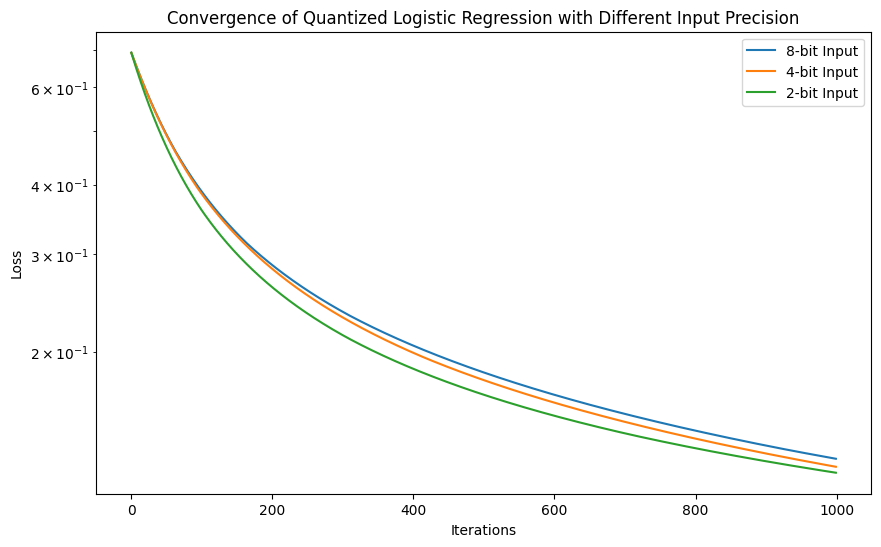

Final accuracy with 8-bit input quantization: 0.9000
Final accuracy with 4-bit input quantization: 0.8667
Final accuracy with 2-bit input quantization: 0.9333


In [21]:
# Custom Quantized Logistic Regression with 4-bit quantized gradient updates
class QuantizedLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, n_iter=1000, gradient_bits=4):
        self.lr = lr
        self.n_iter = n_iter
        self.gradient_bits = gradient_bits
        self.loss_history = []  # Store loss history for convergence analysis
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        
        for _ in range(self.n_iter):
            # Make predictions
            z = np.dot(X, self.weights)
            predictions = 1 / (1 + np.exp(-z))
            
            # Calculate the gradient and quantize it
            error = predictions - y
            gradient = np.dot(X.T, error) / X.shape[0]
            quantized_gradient = quantize_data(gradient, bits=self.gradient_bits)
            
            # Update weights
            self.weights -= self.lr * quantized_gradient
            
            # Calculate loss and store it for analysis
            loss = -np.mean(y * np.log(predictions + 1e-10) + (1 - y) * np.log(1 - predictions + 1e-10))
            self.loss_history.append(loss)

    def predict(self, X):
        z = np.dot(X, self.weights)
        return (1 / (1 + np.exp(-z)) >= 0.5).astype(int)
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights)
        probabilities = 1 / (1 + np.exp(-z))
        return np.column_stack([1 - probabilities, probabilities])

# Experiment with quantized inputs (8, 4, 2-bit) and fixed 4-bit gradient quantization
precisions = [8, 4, 2]
results = {}

for bits in precisions:
    # Quantize input data
    X_train_quantized = quantize_data(X_train, bits)
    X_test_quantized = quantize_data(X_test, bits)
    
    # Use OneVsRestClassifier with the custom logistic regression model
    quantized_logreg_model = OneVsRestClassifier(
        QuantizedLogisticRegression(lr=0.01, n_iter=1000, gradient_bits=4)
    )
    
    # Train and evaluate
    quantized_logreg_model.fit(X_train_quantized, y_train)
    y_pred = quantized_logreg_model.predict(X_test_quantized)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results: accuracy and loss history for each bit precision
    results[bits] = {
        'accuracy': accuracy,
        'loss_history': quantized_logreg_model.estimators_[0].loss_history  # Access the loss history from the first estimator
    }
    print(f"Accuracy with {bits}-bit quantized input and 4-bit quantized gradient: {accuracy:.4f}")

# Plotting the convergence (loss history) for each precision level
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for bits in precisions:
    plt.plot(results[bits]['loss_history'], label=f'{bits}-bit Input')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to logarithmic scale for better comparison
plt.title('Convergence of Quantized Logistic Regression with Different Input Precision')
plt.legend()
plt.show()

# Display accuracies
for bits, metrics in results.items():
    print(f"Final accuracy with {bits}-bit input quantization: {metrics['accuracy']:.4f}")


In [23]:
results[8]['loss_history']

[0.6931471803599453,
 0.6876118147828519,
 0.6821551922553186,
 0.6767761806895803,
 0.6714736545763456,
 0.6662464955218669,
 0.6610935927543828,
 0.6560138436004815,
 0.651006153931981,
 0.6460694385839764,
 0.6412026217447305,
 0.636404637318132,
 0.6316744292594627,
 0.6270109518852501,
 0.6224131701579936,
 0.6178800599465757,
 0.6134106082631783,
 0.6090038134775301,
 0.6046586855093242,
 0.6003742459996394,
 0.5961495284622006,
 0.5919835784153112,
 0.5878754534952836,
 0.5838242235521832,
 0.5798289707286969,
 0.5758887895229168,
 0.5720027868358237,
 0.5681700820042361,
 0.5643898068199728,
 0.5606611055359643,
 0.5569831348600247,
 0.5533550639369794,
 0.5497760743198242,
 0.5462453599305697,
 0.5427621270114067,
 0.5393255940668008,
 0.5359349917971156,
 0.5325895630243275,
 0.5292885626103853,
 0.5260312573687422,
 0.5228169259695682,
 0.5196448588391248,
 0.5165143580537739,
 0.5134247372290615,
 0.5103753214043039,
 0.5073654469230817,
 0.5043944613100295,
 0.501461723144

Accuracy with full-precision logistic regression: 0.9000
No loss history available for 8-bit input.
No loss history available for 4-bit input.
No loss history available for 2-bit input.


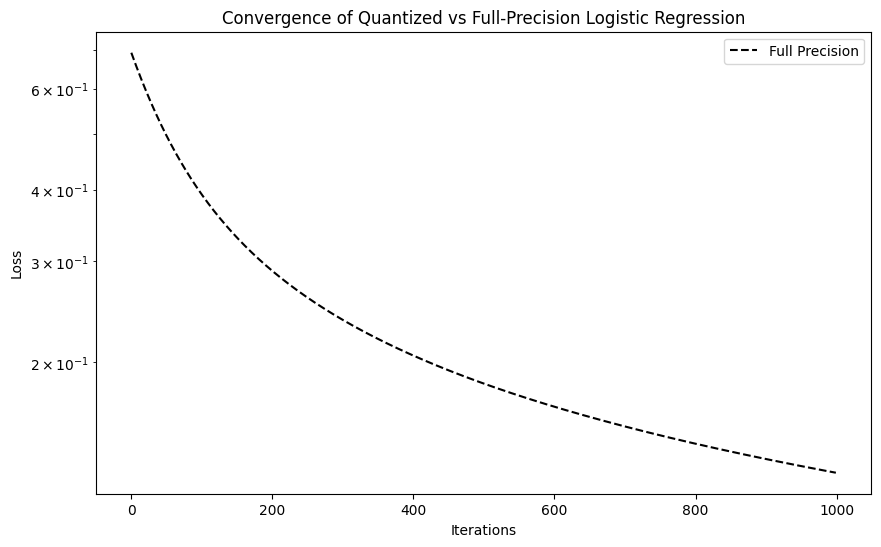

Model Accuracy Comparison:
Accuracy with 8-bit input quantization: 0.9000
Accuracy with 4-bit input quantization: 0.8667
Accuracy with 2-bit input quantization: 0.9333
Accuracy with full_precision-bit input quantization: 0.9000
Accuracy with full-precision logistic regression: 0.9000


In [18]:
# Full Precision Logistic Regression for Comparison
class FullPrecisionLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.loss_history = []  # Store loss history for convergence analysis
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        
        for _ in range(self.n_iter):
            # Make predictions
            z = np.dot(X, self.weights)
            predictions = 1 / (1 + np.exp(-z))
            
            # Calculate the gradient without quantization
            error = predictions - y
            gradient = np.dot(X.T, error) / X.shape[0]
            
            # Update weights with full-precision gradient
            self.weights -= self.lr * gradient
            
            # Calculate and store loss for convergence analysis
            loss = -np.mean(y * np.log(predictions + 1e-10) + (1 - y) * np.log(1 - predictions + 1e-10))
            self.loss_history.append(loss)

    def predict(self, X):
        z = np.dot(X, self.weights)
        return (1 / (1 + np.exp(-z)) >= 0.5).astype(int)
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights)
        probabilities = 1 / (1 + np.exp(-z))
        return np.column_stack([1 - probabilities, probabilities])

# Instantiate and train the full-precision model
full_precision_model = OneVsRestClassifier(
    FullPrecisionLogisticRegression(lr=0.01, n_iter=1000)
)
full_precision_model.fit(X_train, y_train)
y_pred_full_precision = full_precision_model.predict(X_test)
accuracy_full_precision = accuracy_score(y_test, y_pred_full_precision)

# Store full-precision results
results['full_precision'] = {
    'accuracy': accuracy_full_precision,
    'loss_history': full_precision_model.estimators_[0].loss_history  # Access loss history from first estimator
}
print(f"Accuracy with full-precision logistic regression: {accuracy_full_precision:.4f}")

# # Plotting the convergence (loss history) for quantized and full-precision models
# plt.figure(figsize=(10, 6))
# for bits in precisions:
#     plt.plot(results[bits]['loss_history'], label=f'{bits}-bit Input')
# plt.plot(results['full_precision']['loss_history'], label='Full Precision', linestyle='--', color='black')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.yscale('log')  # Set y-axis to logarithmic scale for better comparison
# plt.title('Convergence of Quantized vs Full-Precision Logistic Regression')
# plt.legend()
# plt.show()

# # Display comparison of accuracies
# print("Model Accuracy Comparison:")
# for bits, metrics in results.items():
#     print(f"Accuracy with {bits}-bit input quantization: {metrics['accuracy']:.4f}")
# print(f"Accuracy with full-precision logistic regression: {accuracy_full_precision:.4f}")

# Plotting the convergence (loss history) for quantized and full-precision models
plt.figure(figsize=(10, 6))
for bits in precisions:
    if 'loss_history' in results[bits]:
        plt.plot(results[bits]['loss_history'], label=f'{bits}-bit Input')
    else:
        print(f"No loss history available for {bits}-bit input.")

# Plot loss history for full-precision model
if 'loss_history' in results['full_precision']:
    plt.plot(results['full_precision']['loss_history'], label='Full Precision', linestyle='--', color='black')
else:
    print("No loss history available for full-precision model.")

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to logarithmic scale for better comparison
plt.title('Convergence of Quantized vs Full-Precision Logistic Regression')
plt.legend()
plt.show()

# Display comparison of accuracies
print("Model Accuracy Comparison:")
for bits, metrics in results.items():
    print(f"Accuracy with {bits}-bit input quantization: {metrics.get('accuracy', 'N/A'):.4f}")
print(f"Accuracy with full-precision logistic regression: {accuracy_full_precision:.4f}")
